# UCR Results exploration

This notebook is created for the reasons of analysis of results of semisupervised pipeline experiments on UCR datasets.

In [24]:
from joblib import load
import yaml

from config import (
    MODEL_DIR,
    CONFIG_DIR,
    DATASET_DIR,
    TRAIN_DATASETS,
    TEST_DATASETS
)
from latex_figures import (
    set_size
)
from utils import (
    get_yaml_config,
    read_file
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


%load_ext autoreload
%autoreload 2

%matplotlib inline

tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update(tex_fonts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
EXPERIMENTS = [
    'unsupervised',
    'unsupervised_ae',
    'unsupervised_aev2',
    'unsupervised_vae',
    'unsupervised_vaev2',
]
metrics = ['em', 'mv']
datasets = [d.strip('\n') for d in read_file('./data/test.txt')]
detectors_dict = {
    'knn': 'k-NN',
    'lof': 'LOF',
    'isoforest': 'IF',
    'ocsvm': 'OCSVM',
    'dwtmlead': 'DWTMLEAD',
    'vae': 'VAE',
    'lstmae': 'LSTM EncDec',
    'tranad': 'TranAD',
    'gta': 'GTA',
}
experiments_dict = {
    'unsupervised': 'US',
    'unsupervised_ae': 'EUS',
    'unsupervised_aev2': 'EUS-AE',
    'unsupervised_vae': 'EUSv',
    'unsupervised_vaev2': 'EUS-VAE',
}


## Baseline
This experiment serves as a baseline for other experiments.

Key features:
* Completely unsupervised
* No AutoML used
* Default parameters of anomaly detectors used for learning

In [26]:
# Read data
baseline_df = pd.read_csv('./results/baseline_results.csv', sep=',', header=0)
baseline_df['detector'] = baseline_df['detector'].map(detectors_dict)
baseline_df['exp'] = 'Base'
baseline_df.head()

,detector,dataset,f1,f1_pa_auc,f1_pa,f1_pa_ts_auc,aucpr,aucroc,time,exp
0,k-NN,104_UCR_Anomaly_NOISEapneaecg4_6000_16000_1610...,0.007272,0.012240,0.034855,0.003090,0.002875,0.489696,48.710795,Base
1,k-NN,023_UCR_Anomaly_DISTORTEDGP711MarkerLFM5z5_500...,0.912281,0.912041,1.000000,0.929191,0.980046,0.999685,12.091918,Base
2,k-NN,156_UCR_Anomaly_TkeepFifthMARS_3500_5988_6085.txt,0.858586,0.913157,1.000000,0.680000,0.916211,0.998983,3.113165,Base
3,k-NN,115_UCR_Anomaly_CIMIS44AirTemperature3_4000_65...,0.540541,0.654412,1.000000,0.126000,0.507032,0.985757,2.086034,Base
4,k-NN,113_UCR_Anomaly_CIMIS44AirTemperature1_4000_53...,0.009804,0.000000,0.009662,0.009662,0.002463,0.951709,2.713126,Base


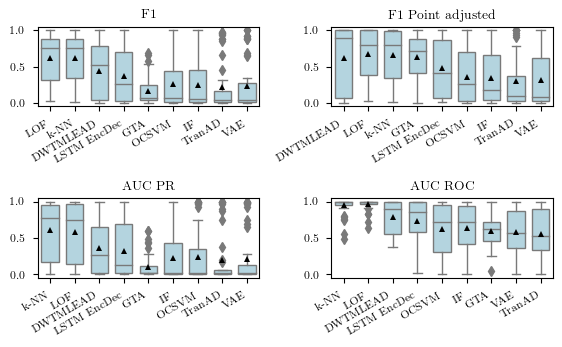

In [27]:
fig, axs = plt.subplots(2, 2, figsize=set_size(subplots=(2, 2)))
to_label = dict(
    f1='F1', f1_pa='F1 Point adjusted', aucpr='AUC PR', aucroc='AUC ROC'
)
for i, y in enumerate(['f1', 'f1_pa', 'aucpr', 'aucroc']):
    ax = axs[i // 2][i % 2]

    order = (
        baseline_df.groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )

    ax = sns.boxplot(
        data=baseline_df,
        y=y,
        x='detector',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=30, horizontalalignment='right'
    )

plt.tight_layout()
plt.show()
# fig.savefig('images/baseline.pdf', format='pdf', bbox_inches='tight')


## AutoML using unsupervised metrics

This experiments is mainly focused on Mass volume and Excess mass metrics.

Experiments from now on are evaluated only with F1 score and AUC PR as AUC ROC
isn't useful due to natural inbalance in anomalies and non-anomalies and point
adjusted evaluation scheme isn't used as it has been shown it can overestimate
performance of detectors.

Key features:

* Mass volume and Excess mass metrics used to tune hyperparameters

Research questions: 

* Is one superior to another in our results?
* Do they actually work for time series?
* Can they be used to compare between detectors?



In [28]:
# Read results
dataframes = []
for exp in EXPERIMENTS:
    detectors = get_yaml_config('./config/' + exp)['detectors']

    records = []
    for d in detectors:
        for m in metrics:
            for dt in datasets:
                with open(f'./model/{d}/{exp}/{dt}/{m}.yaml') as f:
                    r = yaml.unsafe_load(f)
                    r['detector'] = detectors_dict[d]
                    r['metric_value'] = r.pop('metric')
                    r['metric'] = 'EM' if m == 'em' else 'MV'
                    r['dataset'] = dt
                    r['exp'] = experiments_dict[exp]
                    records.append(r)
    dataframes.append(pd.DataFrame.from_records(records))

us1_df = dataframes[0]  # unsupervised default experiment
us2_df = dataframes[1]  # unsupervised autoencoder instead of random sampling
us3_df = dataframes[2]  # unsupervised autoencoder within the metric
us4_df = dataframes[3]  # unsupervised VAE instead of random sampling
us5_df = dataframes[4]  # unsupervised VAE within the metric


Comparison of MV and EM metrics on individual models of US pipeline

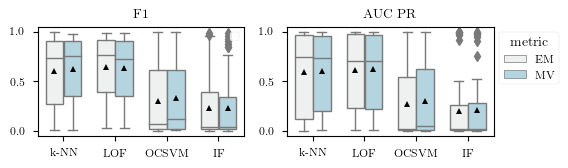

In [29]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    order = (
        us1_df.groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )
    ax = sns.boxplot(
        data=us1_df,
        y=y,
        x='detector',
        hue='metric',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])
sns.move_legend(axs[1], 'upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()
# fig.savefig('images/us1.pdf', format='pdf', bbox_inches='tight')


Comparison of metrics across all models

/tmp/ipykernel_2986667/1704002881.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = us1_df.groupby(['metric', 'dataset']).median()


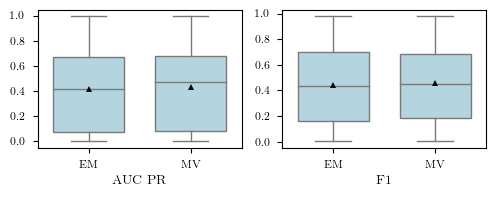

In [30]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
d = us1_df.groupby(['metric', 'dataset']).median()
ax = sns.boxplot(
    data=d.reset_index(),
    y='f1',
    x='metric',
    color='lightblue',
    ax=axs[1],
    linewidth=1,
    width=0.7,
    showmeans=True,
    meanprops={
        'marker': '^',
        'markerfacecolor': 'black',
        'markeredgecolor': 'black',
        'markersize': '4',
    },
)
ax.set_xlabel('F1')
ax.set_ylabel('')
ax = sns.boxplot(
    data=d.reset_index(),
    y='aucpr',
    x='metric',
    color='lightblue',
    ax=axs[0],
    linewidth=1,
    width=0.7,
    showmeans=True,
    meanprops={
        'marker': '^',
        'markerfacecolor': 'black',
        'markeredgecolor': 'black',
        'markersize': '4',
    },
)
ax.set_xlabel('AUC PR')
ax.set_ylabel('')
plt.show()
# fig.savefig('images/metrics.pdf', format='pdf', bbox_inches='tight')


Nearly 2% gain on F1 score and ~11% gain on AUCPR in median value. Nevertheless, the difference is insignificant and for the reason of similarity only MV is showed for the rest of visualizations.

In [31]:
print(d.loc['MV', 'f1'].median() / d.loc['EM', 'f1'].median())
print(d.loc['MV', 'aucpr'].median() / d.loc['EM', 'aucpr'].median())


1.0265733303595204
1.116386345717296


#### Comparison against baseline

Limitation of these metrics is that they use MC simulation to compute Lebesgue integral therefore the dimension of input data can't be to high due to limited computational power.

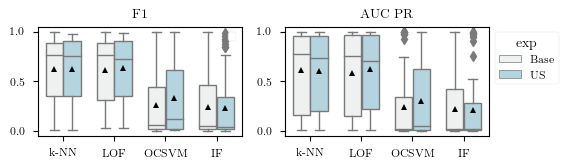

In [32]:
tmp_df = pd.concat([baseline_df, us1_df[us1_df['metric'] == 'MV']])
to_label = dict(
    f1='F1', f1_pa='F1 Point adjusted', aucpr='AUC PR', aucroc='AUC ROC'
)
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    ax = sns.boxplot(
        data=tmp_df,
        y=y,
        x='detector',
        hue='exp',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])
sns.move_legend(axs[1], 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
# fig.savefig(
#     'images/base_us1_comparison.pdf', format='pdf', bbox_inches='tight'
# )


#### Comparison of potential US upper bound to baseline

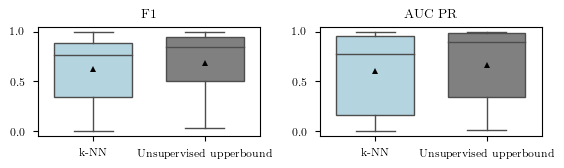

In [33]:
baseline_df['Experiment'] = 'Base'
to_label = dict(
    f1='F1', f1_pa='F1 Point adjusted', aucpr='AUC PR', aucroc='AUC ROC'
)
knn_base = baseline_df[baseline_df['detector'] == 'k-NN']
d = us1_df.groupby(['metric', 'dataset']).max().reset_index()
d = d[d['metric'] == 'MV']
tmp_df = pd.concat([knn_base, d])

fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]

    ax = sns.boxplot(
        data=tmp_df,
        y=y,
        x='exp',
        ax=ax,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
        palette={
            'US': 'grey',
            'Base': 'lightblue',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels(['k-NN', 'Unsupervised upperbound'])
#     if i != 1:
#         ax.legend([])
# sns.move_legend(axs[1], 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
# fig.savefig(
#     'images/base_potential_upperbound.pdf', format='pdf', bbox_inches='tight'
# )


EUS pipelines results are observed. Performance is significantly worse.

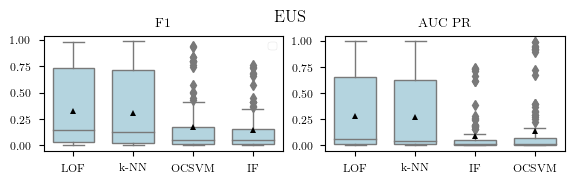

In [34]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    order = (
        us2_df[us2_df['metric'] == 'MV']
        .groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )
    ax = sns.boxplot(
        data=us2_df,
        y=y,
        x='detector',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])

fig.suptitle('EUS', y=1)
fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()
# fig.savefig('images/us2.pdf', format='pdf', bbox_inches='tight')


## EUS-AE: Autoencoder within unsupervised metrics 

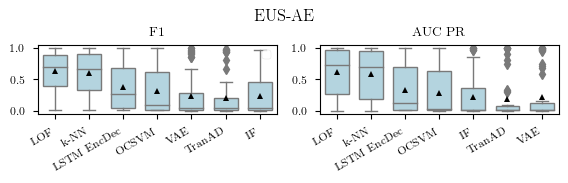

In [35]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    order = (
        us3_df[us3_df['metric'] == 'MV']
        .groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )
    ax = sns.boxplot(
        data=us3_df[us3_df['metric'] == 'MV'],
        y=y,
        x='detector',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])

    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=30, horizontalalignment='right'
    )


fig.suptitle('EUS-AE', y=1)
fig.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()
# fig.savefig('images/us3.pdf', format='pdf', bbox_inches='tight')


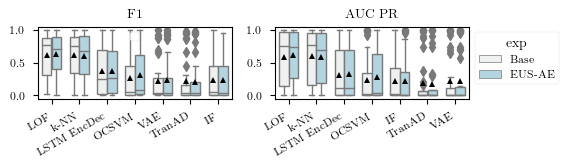

In [36]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
tmp_df = pd.concat(
    [
        baseline_df.query('detector not in ["GTA", "DWTMLEAD"]'),
        us3_df[us3_df['metric'] == 'MV'],
    ]
)

for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    order = (
        us3_df[us3_df['metric'] == 'MV']
        .groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )
    ax = sns.boxplot(
        data=tmp_df,
        y=y,
        x='detector',
        ax=ax,
        hue='exp',
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])

    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=30, horizontalalignment='right'
    )

sns.move_legend(axs[1], 'upper left', bbox_to_anchor=(1, 1))
fig.tight_layout()
plt.show()
# fig.savefig('images/us3_.pdf', format='pdf', bbox_inches='tight')


## EUS-VAE: VAE within unsupervised metrics 

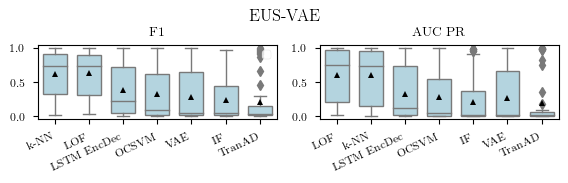

In [37]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    order = (
        us5_df[us5_df['metric'] == 'MV']
        .groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )
    ax = sns.boxplot(
        data=us5_df[us5_df['metric'] == 'MV'],
        y=y,
        x='detector',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])

    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=25, horizontalalignment='right'
    )

fig.suptitle('EUS-VAE', y=1)
fig.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()
# fig.savefig('images/us5.pdf', format='pdf', bbox_inches='tight')


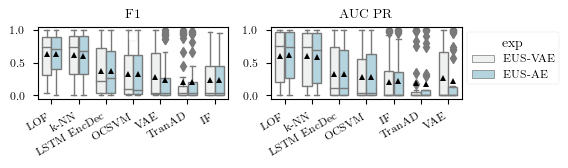

In [38]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
tmp_df = pd.concat(
    [us5_df[us5_df['metric'] == 'MV'], us3_df[us3_df['metric'] == 'MV']]
)

for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    order = (
        us3_df[us3_df['metric'] == 'MV']
        .groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )
    ax = sns.boxplot(
        data=tmp_df,
        y=y,
        x='detector',
        ax=ax,
        hue='exp',
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])

    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=30, horizontalalignment='right'
    )

sns.move_legend(axs[1], 'upper left', bbox_to_anchor=(1, 1))
fig.tight_layout()
plt.show()
# fig.savefig('images/us5_.pdf', format='pdf', bbox_inches='tight')


Comparison of all potential pipeline upperbounds using the MV metric against baseline of k-NN

/tmp/ipykernel_2986667/443707777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_df.loc[:, 'exp'] = 'k-NN'
/tmp/ipykernel_2986667/443707777.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .median()['aucpr']


<Axes.ArtistList of 0 artists>


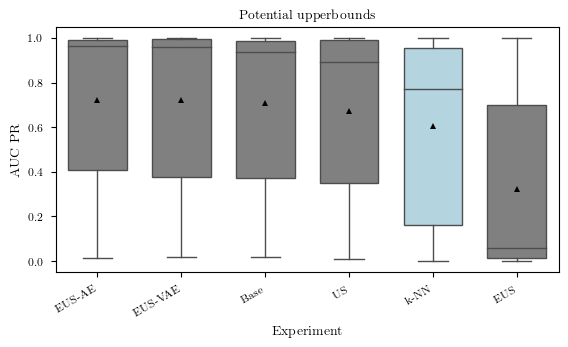

In [39]:
knn_df = baseline_df[baseline_df['detector'] == 'k-NN']
knn_df.loc[:, 'exp'] = 'k-NN'
tmp_df = pd.concat([knn_df, baseline_df, us1_df, us2_df, us3_df, us5_df])
tmp = tmp_df.groupby(['exp', 'dataset']).max().reset_index()
order = (
    tmp_df.groupby(by=['exp', 'dataset'])
    .max()
    .groupby('exp')
    .median()['aucpr']
    .sort_values(ascending=False)
    .index.tolist()
)
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1)))
ax = sns.boxplot(
    data=tmp,
    x='exp',
    y='aucpr',
    linewidth=1,
    width=0.7,
    order=order,
    ax=ax,
    showmeans=True,
    meanprops={
        'marker': '^',
        'markerfacecolor': 'black',
        'markeredgecolor': 'black',
        'markersize': '4',
    },
    palette={
        'EUS-AE': 'grey',
        'EUS-VAE': 'grey',
        'k-NN': 'lightblue',
        'Base': 'grey',
        'US': 'grey',
        'EUS': 'grey',
    },
)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=30, horizontalalignment='right'
)
ax.set_xlabel('Experiment')
ax.set_ylabel('AUC PR')
print(ax.artists)
ax.set_title('Potential upperbounds')

plt.tight_layout()
plt.show()
# fig.savefig('images/us_vs_base.pdf', format='pdf', bbox_inches='tight')


## META pipelines

In [40]:
records = []
best_models = load('./results/best_models_0.joblib')
for model, dataset in best_models:
    r = (
        baseline_df[
            (baseline_df['detector'] == detectors_dict[model])
            & (baseline_df['dataset'] == dataset)
        ]
        .iloc[0]
        .to_dict()
    )
    r['metric_value'] = 0
    r['metric'] = 'Base'
    records.append(r)


meta_df1 = pd.DataFrame.from_records(records)
meta_df1['exp'] = 'META_base'


In [41]:
records = []
best_models = load('./results/best_models_0.joblib')
for model, dataset in best_models:
    if model not in ['gta', 'dwtmlead']:
        with open(f'./model/{model}/unsupervised_aev2/{dataset}/mv.yaml') as f:
            r = yaml.unsafe_load(f)
            r['detector'] = detectors_dict[model]
            r['metric_value'] = r.pop('metric')
            r['metric'] = 'MV'
            r['dataset'] = dataset
            records.append(r)
    else:
        if model == 'dwtmlead':
            r = (
                baseline_df[
                    (baseline_df['detector'] == 'DWTMLEAD')
                    & (baseline_df['dataset'] == dataset)
                ]
                .iloc[0]
                .to_dict()
            )
            r['metric_value'] = 0
            r['metric'] = 'Base'
            records.append(r)
        if model == 'gta':
            r = (
                baseline_df[
                    (baseline_df['detector'] == 'GTA')
                    & (baseline_df['dataset'] == dataset)
                ]
                .iloc[0]
                .to_dict()
            )
            r['metric_value'] = 0
            r['metric'] = 'Base'
            records.append(r)

meta_df = pd.DataFrame.from_records(records)
meta_df['exp'] = 'META'


In [42]:
records = []
best_models = load('./results/best_models_tsfresh.joblib')
for model, dataset in best_models:
    if model not in ['gta', 'dwtmlead']:
        with open(f'./model/{model}/unsupervised_aev2/{dataset}/mv.yaml') as f:
            r = yaml.unsafe_load(f)
            r['detector'] = detectors_dict[model]
            r['metric_value'] = r.pop('metric')
            r['metric'] = 'MV'
            r['dataset'] = dataset
            records.append(r)
    else:
        if model == 'dwtmlead':
            r = (
                baseline_df[
                    (baseline_df['detector'] == 'DWTMLEAD')
                    & (baseline_df['dataset'] == dataset)
                ]
                .iloc[0]
                .to_dict()
            )
            r['metric_value'] = 0
            r['metric'] = 'Base'
            records.append(r)
        if model == 'gta':
            r = (
                baseline_df[
                    (baseline_df['detector'] == 'GTA')
                    & (baseline_df['dataset'] == dataset)
                ]
                .iloc[0]
                .to_dict()
            )
            r['metric_value'] = 0
            r['metric'] = 'Base'
            records.append(r)

meta_tsfresh_df = pd.DataFrame.from_records(records)
meta_tsfresh_df['exp'] = 'META-ts'


In [43]:
records = []
best_models = load('./results/best_models_tsfresh.joblib')
for model, dataset in best_models:
    r = (
        baseline_df[
            (baseline_df['detector'] == detectors_dict[model])
            & (baseline_df['dataset'] == dataset)
        ]
        .iloc[0]
        .to_dict()
    )
    r['metric_value'] = 0
    r['metric'] = 'Base'
    records.append(r)

meta_tsfreshbase_df = pd.DataFrame.from_records(records)
meta_tsfreshbase_df['exp'] = 'META-ts_base'


Plot performance of all meta pipelines against potenital baseline and baselines of k-NN.

/tmp/ipykernel_2986667/3413535681.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .median()['aucpr']


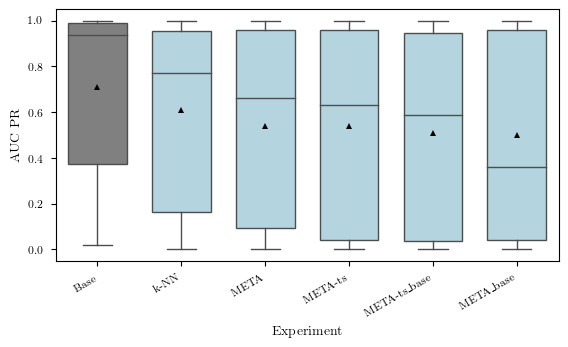

In [44]:
tmp_df = pd.concat(
    [
        knn_df,
        baseline_df,
        meta_df,
        meta_tsfresh_df,
        meta_df1,
        meta_tsfreshbase_df,
    ]
)
tmp = tmp_df.groupby(['exp', 'dataset']).max().reset_index()
order = (
    tmp_df.groupby(by=['exp', 'dataset'])
    .max()
    .groupby('exp')
    .median()['aucpr']
    .sort_values(ascending=False)
    .index.tolist()
)

fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1)))
sns.boxplot(
    data=tmp,
    x='exp',
    y='aucpr',
    color='lightblue',
    linewidth=1,
    width=0.7,
    order=order,
    ax=ax,
    showmeans=True,
    meanprops={
        'marker': '^',
        'markerfacecolor': 'black',
        'markeredgecolor': 'black',
        'markersize': '4',
    },
    palette={
        'k-NN': 'lightblue',
        'META': 'lightblue',
        'META-ts': 'lightblue',
        'EUS': 'grey',
        'META_base': 'lightblue',
        'META-ts_base': 'lightblue',
        'Base': 'grey',
    },
)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=30, horizontalalignment='right'
)
ax.set_xlabel('Experiment')
ax.set_ylabel('AUC PR')
plt.tight_layout()
plt.show()
# fig.savefig('images/meta_us_vs_base.pdf', format='pdf', bbox_inches='tight')


## Metafeatures UMAP projection of train and test datasets with 

In [45]:
train_datasets = [d.strip('\n') for d in read_file('./data/train.txt')]
test_datasets = [d.strip('\n') for d in read_file('./data/test.txt')]

train_meta_mat = np.zeros([len(train_datasets), 200])
for i, ds in enumerate(train_datasets):
    train_meta_mat[i, :] = np.load(f'./data/datasets/metafeatures/{ds}.npy')
train_meta_mat = np.nan_to_num(train_meta_mat, nan=0)

test_meta_mat = np.zeros([len(test_datasets), 200])
for i, ds in enumerate(test_datasets):
    test_meta_mat[i, :] = np.load(f'./data/datasets/metafeatures/{ds}.npy')
test_meta_mat = np.nan_to_num(test_meta_mat, nan=0)


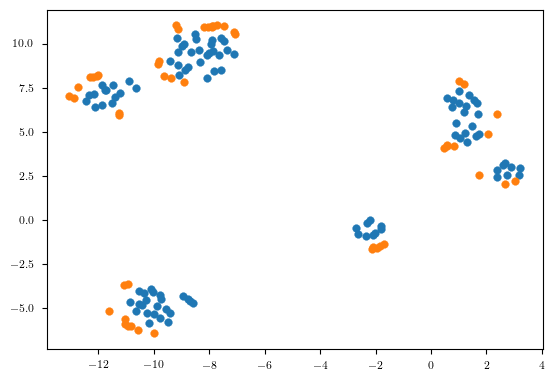

In [46]:
import umap

ump = umap.UMAP(n_neighbors=80, n_components=2, min_dist=0.5)
train_emb = ump.fit_transform(train_meta_mat)
test_emb = ump.transform(test_meta_mat)

x, y = zip(*train_emb)
plt.scatter(x, y)
x, y = zip(*test_emb)
plt.scatter(x, y)


In [47]:
train_datasets = [d.strip('\n') for d in read_file('./data/train.txt')]
test_datasets = [d.strip('\n') for d in read_file('./data/test.txt')]

train_meta_mat = np.zeros([len(train_datasets), 777])
for i, ds in enumerate(train_datasets):
    train_meta_mat[i, :] = np.load(
        f'./data/datasets/metafeatures/tsfresh_{ds}.npy'
    )
train_meta_mat = np.nan_to_num(train_meta_mat, nan=0)

test_meta_mat = np.zeros([len(test_datasets), 777])
for i, ds in enumerate(test_datasets):
    test_meta_mat[i, :] = np.load(
        f'./data/datasets/metafeatures/tsfresh_{ds}.npy'
    )
test_meta_mat = np.nan_to_num(test_meta_mat, nan=0)


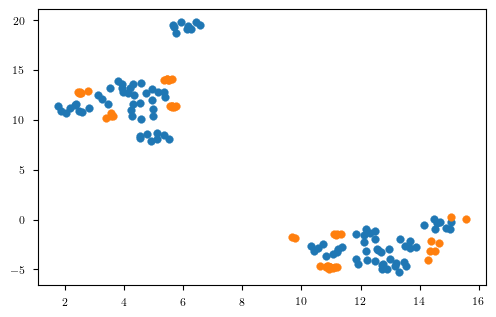

In [48]:
import umap

ump = umap.UMAP(n_neighbors=40, n_components=2, min_dist=0.5)
train_emb = ump.fit_transform(train_meta_mat)
test_emb = ump.transform(test_meta_mat)
fig, axs = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1)))
x, y = zip(*train_emb)
plt.scatter(x, y)
x, y = zip(*test_emb)
plt.scatter(x, y)
# fig.savefig('images/umap_datasets.pdf', format='pdf', bbox_inches='tight')
